# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
  1
  1
 -1
 -1
 -1
 -1
  1
  1
 -1
 -1
  ⋮
  1
  1
  1
  1
  1
 -1
 -1
 -1
  1

### We create a function to visualize the data

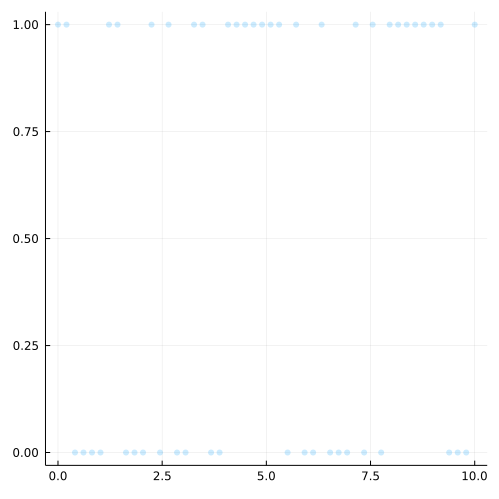

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  0.941765 seconds (1.82 M allocations: 103.779 MiB, 99.55% compilation time)


(Variational Gaussian Process with a BernoulliLikelihood{GPLikelihoods.LogisticLink}(GPLikelihoods.LogisticLink()) infered by Analytic Variational Inference , (local_vars = (c = [0.725777979929387, 0.6859287154443331, 0.6707633943871769, 0.6796759307037161, 0.7035038151238994, 0.7306211994807161, 0.7522920518493406, 0.7645120881197117, 0.7667458942826801, 0.7601443945448166  …  1.0123297049557123, 1.0739899941257116, 1.0730135910623995, 1.013188379370298, 0.9119609884079565, 0.7981913608418701, 0.7070051227353312, 0.6670322382922225, 0.6818277030061936, 0.7306427324662016], θ = [0.23957477526178744, 0.2406381805980076, 0.2410299611603108, 0.2408005893163248, 0.2401751790661542, 0.23944223881182342, 0.2388406472125928, 0.2384953190077112, 0.23843172382470698, 0.23861924640668863  …  0.2306322016697824, 0.22845181324862482, 0.2284869427529465, 0.23060238471473637, 0.234002634628867, 0.23752131644477878, 0.2400818021832229, 0.24112524147649478, 0.2407448375887129, 0.23944164798254994]), o

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:05:12
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:38
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:45
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:19
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:03
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:52
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:44
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:39
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:34
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:31
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:28
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:25
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[-0.8479384169567894, -1.1007536063760626, -1.1932573338161718, -1.1908135990663682, -1.2121895450484776, -1.2313024595079651, -1.3011798164685167, -1.4239819129353428, -1.5930616310875343, -1.711375516137872  …  1.0499554929945043, 0.8718761720489785, 0.6301982291224848, 0.37531747899231727, 0.10401345062698336, -0.1681764346415664, -0.43172494597439937, -0.6477896733524016, -0.8025848170976936, -0.8339940479374319]]
 [[0.5111390792946517, 0.38490171788765604, 0.27120092543687624, 0.1511210490611437, 0.08036614269909892, 0.0572641487685997, 0.08675474668797722, 0.10312826051059831, 0.11385581390574906, 0.09548052675529684  …  1.3633496695478293, 1.3960054392888162, 1.2931243530907925, 1.0294634417777975, 0.644546615388681, 0.2685347907445857, -0.09481467821601486, -0.31895614248119825, -0.38340013235860004, -0.313518606817675]]
 [[0.4476972654061796, 0.49324926357010773, 0.5334627601731251, 0.578802104188223, 0.5632081432168436, 0.513978

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

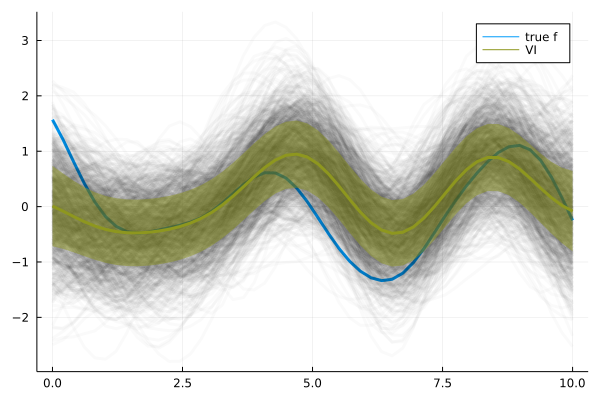

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

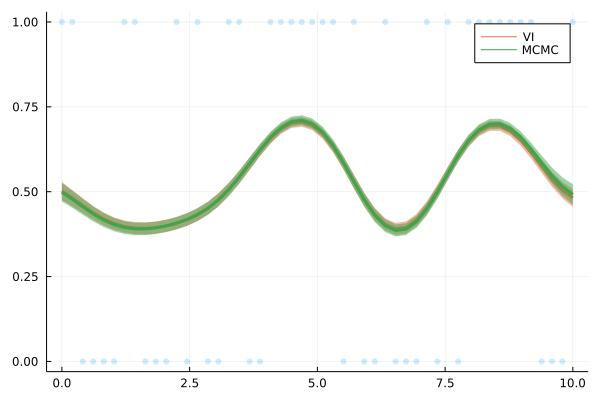

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*